<a href="https://colab.research.google.com/github/SobolMaria/Maria_Sobol/blob/main/11_GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = tf.nn.relu(x)

    x = self.layer_2(x)
    x = tf.nn.relu(x)

    return self.output_layer(x, activation=1)

In [8]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1, output_type=tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    correct_predictions = tf.equal(y_pred, y_true)

    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [9]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)

        print(f"Step: {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")


Step: 100, Loss: 270.0458, Accuracy: 0.6641
Step: 200, Loss: 185.1134, Accuracy: 0.7969
Step: 300, Loss: 152.0633, Accuracy: 0.8086
Step: 400, Loss: 120.7084, Accuracy: 0.8516
Step: 500, Loss: 130.0066, Accuracy: 0.8633
Step: 600, Loss: 85.8376, Accuracy: 0.9180
Step: 700, Loss: 136.5739, Accuracy: 0.8477
Step: 800, Loss: 79.6729, Accuracy: 0.9023
Step: 900, Loss: 116.1152, Accuracy: 0.8711
Step: 1000, Loss: 86.9013, Accuracy: 0.9023
Step: 1100, Loss: 97.7249, Accuracy: 0.8789
Step: 1200, Loss: 101.8378, Accuracy: 0.8789
Step: 1300, Loss: 94.9753, Accuracy: 0.8672
Step: 1400, Loss: 68.1185, Accuracy: 0.9062
Step: 1500, Loss: 71.0590, Accuracy: 0.9023
Step: 1600, Loss: 51.0539, Accuracy: 0.9375
Step: 1700, Loss: 53.5223, Accuracy: 0.9375
Step: 1800, Loss: 73.7059, Accuracy: 0.9141
Step: 1900, Loss: 66.3305, Accuracy: 0.9297
Step: 2000, Loss: 72.4230, Accuracy: 0.8984
Step: 2100, Loss: 81.0483, Accuracy: 0.9062
Step: 2200, Loss: 108.5748, Accuracy: 0.8789
Step: 2300, Loss: 70.4076, Accur

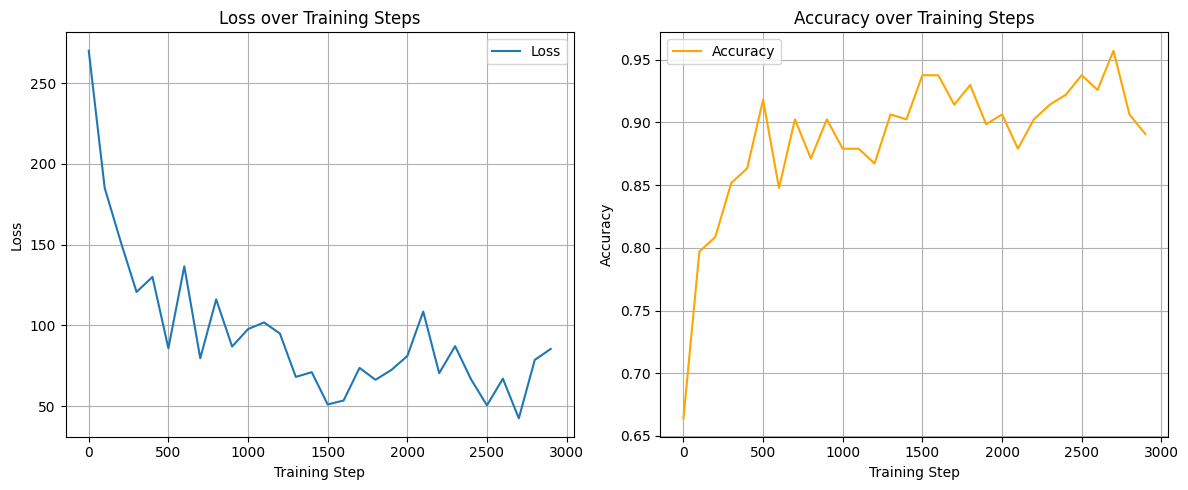

In [10]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Виведіть графік функції втрат
plt.subplot(1, 2, 1)
plt.plot(range(0, training_steps, display_step), loss_history, label="Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss over Training Steps")
plt.legend()
plt.grid()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(0, training_steps, display_step), accuracy_history, label="Accuracy", color='orange')
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Accuracy over Training Steps")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [11]:
# Обчисліть точність навченої нейромережі
def evaluate_model(neural_net, x_test, y_test):
    predictions = neural_net(x_test)

    test_accuracy = accuracy(predictions, y_test)
    return test_accuracy

# Тестування моделі на тестових даних
test_accuracy = evaluate_model(neural_net, x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9056


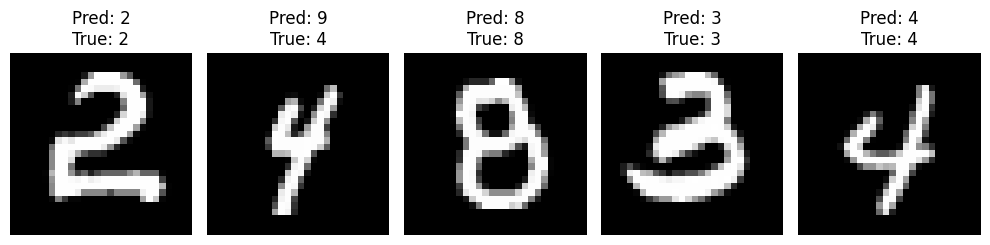

Accuracy on the random sample: 0.8000


In [18]:
import matplotlib.pyplot as plt

# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5 випадкових зображень і передайте їх у нейронну мережу.
num_samples = 5
random_indices = random.sample(range(x_test.shape[0]), num_samples)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

predictions = neural_net(sample_images)
predicted_labels = tf.argmax(predictions, axis=1)


# Виведіть зображення та випишіть  поруч відповідь нейромережі.
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.title(f"Pred: {predicted_labels[i].numpy()}\nTrue: {sample_labels[i]}")

plt.tight_layout()
plt.show()

correct_predictions = tf.equal(predicted_labels, sample_labels)
accuracy_on_samples = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
print(f"Accuracy on the random sample: {accuracy_on_samples:.4f}")

# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

Отже, з 5 малюнків модель зробила одну помилку. Точніть моделі на випадковій вибірці 80%. Модель погано розрізняє цифри 4 та 9.